In [1]:
import tensorflow as tf
import json
import os

from core.data  import load_records
from core.transformer import ASTROMER
from core.scheduler import CustomSchedule
from core.callbacks import get_callbacks
from core.losses import CustomMSE, ASTROMERLoss, CustomBCE
from core.metrics import CustomACC

import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [14]:
root_data = './experiments/macho_magn_time_normed'
conf_file = os.path.join(root_data, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'time_normed': True,
 'magn_normed': True,
 'data': './data/records/macho',
 'p': './experiments/macho_magn_time_normed',
 'batch_size': 512,
 'epochs': 1000,
 'layers': 2,
 'heads': 4,
 'head_dim': 512,
 'dff': 1024,
 'pe': 200,
 'dropout': 0.1,
 'lr': 0.001}

In [15]:
test_batches = load_records(os.path.join(conf['data'], 'test'), 
                                          conf['batch_size'], 
                                          magn_normed=conf['magn_normed'],
                                          time_normed=conf['time_normed'],
                                          shifted=False)

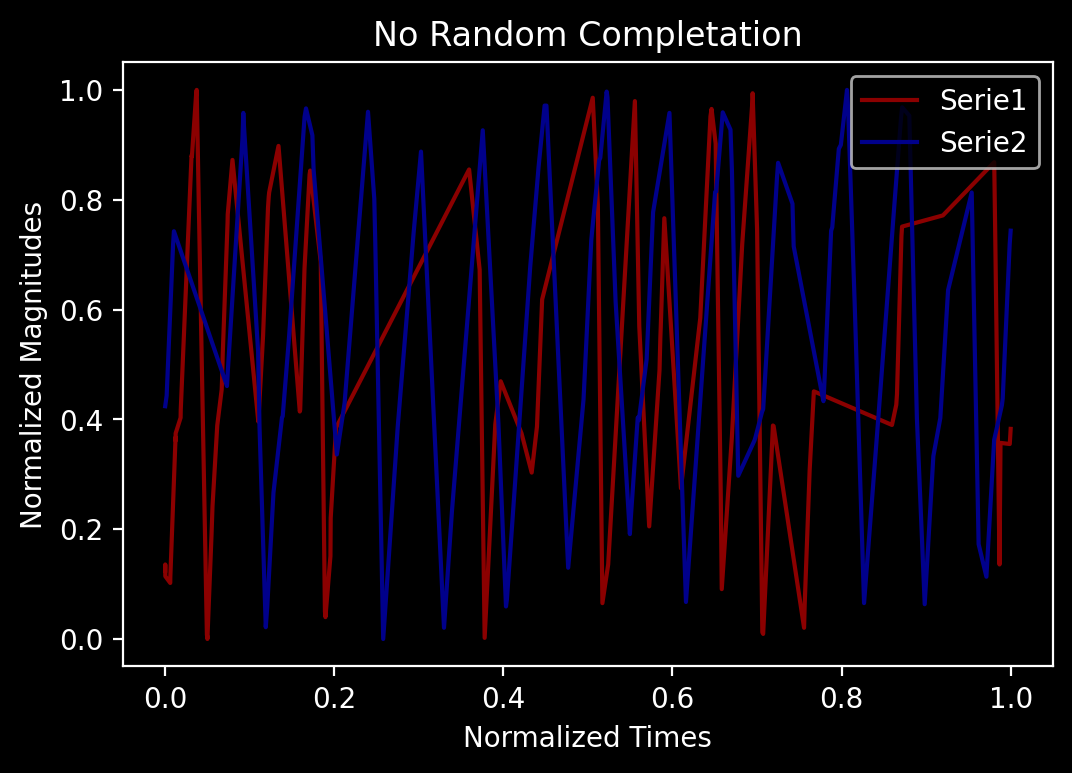

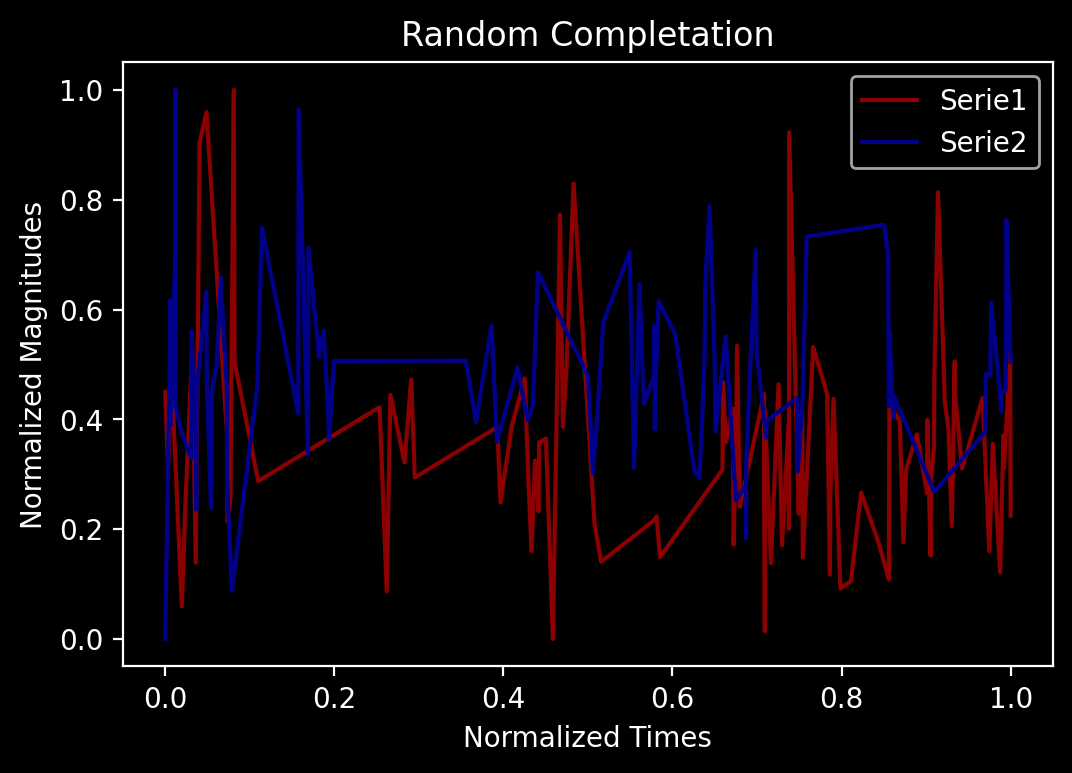

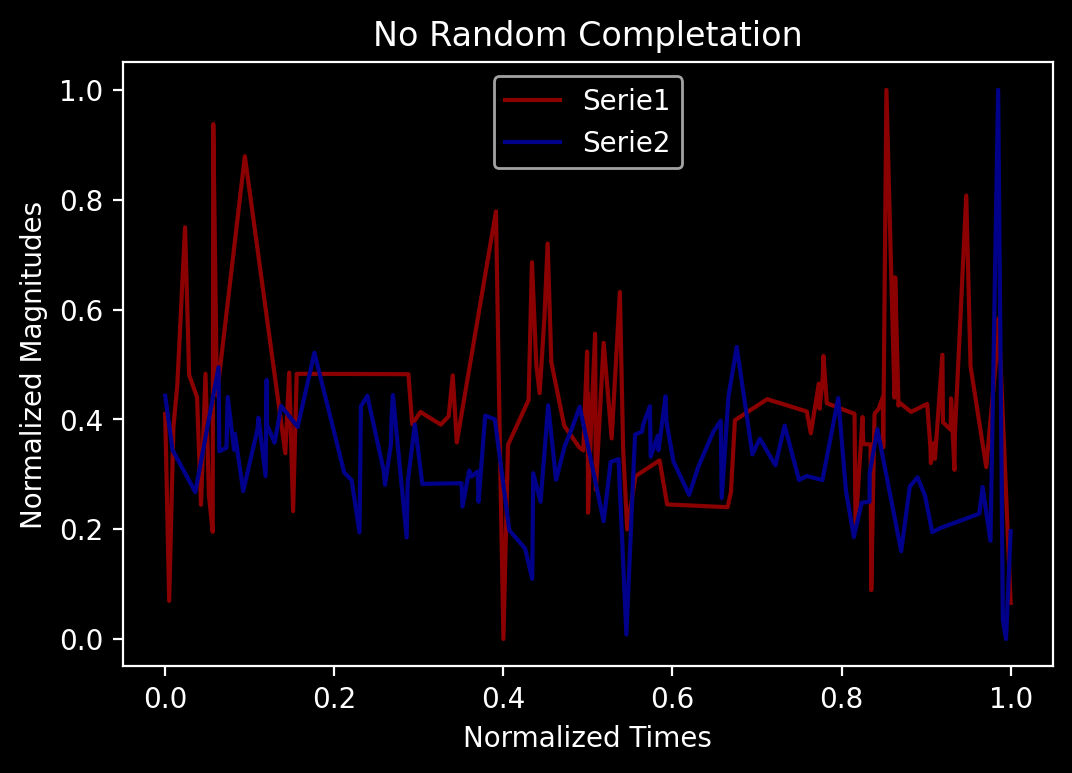

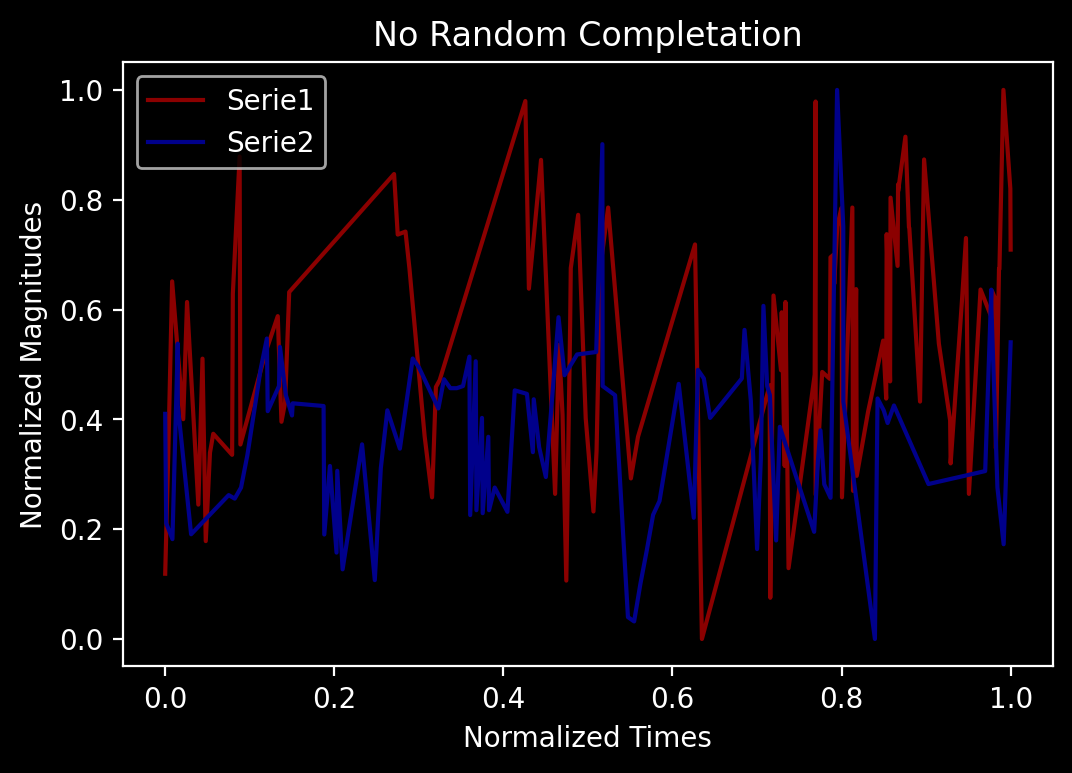

In [16]:

count = 0
for x1, x2, t, y in test_batches.unbatch():
    plt.figure(dpi=200)
    plt.plot(x1[:, 0], x1[:, 1], color='darkred', label='Serie1')
    plt.plot(x2[:, 0], x2[:, 1], color='darkblue', label='Serie2')
    plt.xlabel('Normalized Times')
    plt.ylabel('Normalized Magnitudes')
    plt.legend()
    name = 'Random Completation' if y.numpy()[0] == 1 else 'No Random Completation'
    plt.title(name)
    plt.show()
    if count == 3: break
    count+=1

In [17]:
learning_rate = 1e-3#CustomSchedule(opt.head_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Model Instance
transformer = ASTROMER(num_layers=conf['layers'],
                    d_model=conf['head_dim'],
                    num_heads=conf['heads'],
                    dff=conf['dff'],
                    pe_input=conf['pe'],
                    rate=conf['dropout'])
# Compile
transformer.compile(optimizer=optimizer, 
                    loss=ASTROMERLoss(),
                    metrics=[CustomMSE(), CustomBCE(), CustomACC()])
# Create graph
transformer.model(conf['batch_size']).summary()

# Initialize graph
transformer.evaluate(test_batches.take(1))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(512, 202, 2)]      0                                            
__________________________________________________________________________________________________
Serie2 (InputLayer)             [(512, 202, 2)]      0                                            
__________________________________________________________________________________________________
TrueLength (InputLayer)         [(512,)]             0                                            
__________________________________________________________________________________________________
IsRandom (InputLayer)           [(512, 1)]           0                                            
____________________________________________________________________________________________

[10073.9599609375, 10072.412109375, 1.5479216575622559, 0.494140625]

In [18]:
expdir = '{}/train_model.h5'.format(conf['p'])
transformer.load_weights(expdir)
transformer.evaluate(test_batches)

2/2 [==============================] - 12s 86ms/step - loss: 2.1357 - RMSE: 1.9890 - BCE: 0.6259 - Accuracy: 1.0000


[2.1356582641601562, 1.9889655113220215, 0.6258852481842041, 1.0]

In [19]:
rec_pred, rec_mask, rec_true, rec_times, cls_pred, cls_true = transformer.predict(test_batches.take(1))

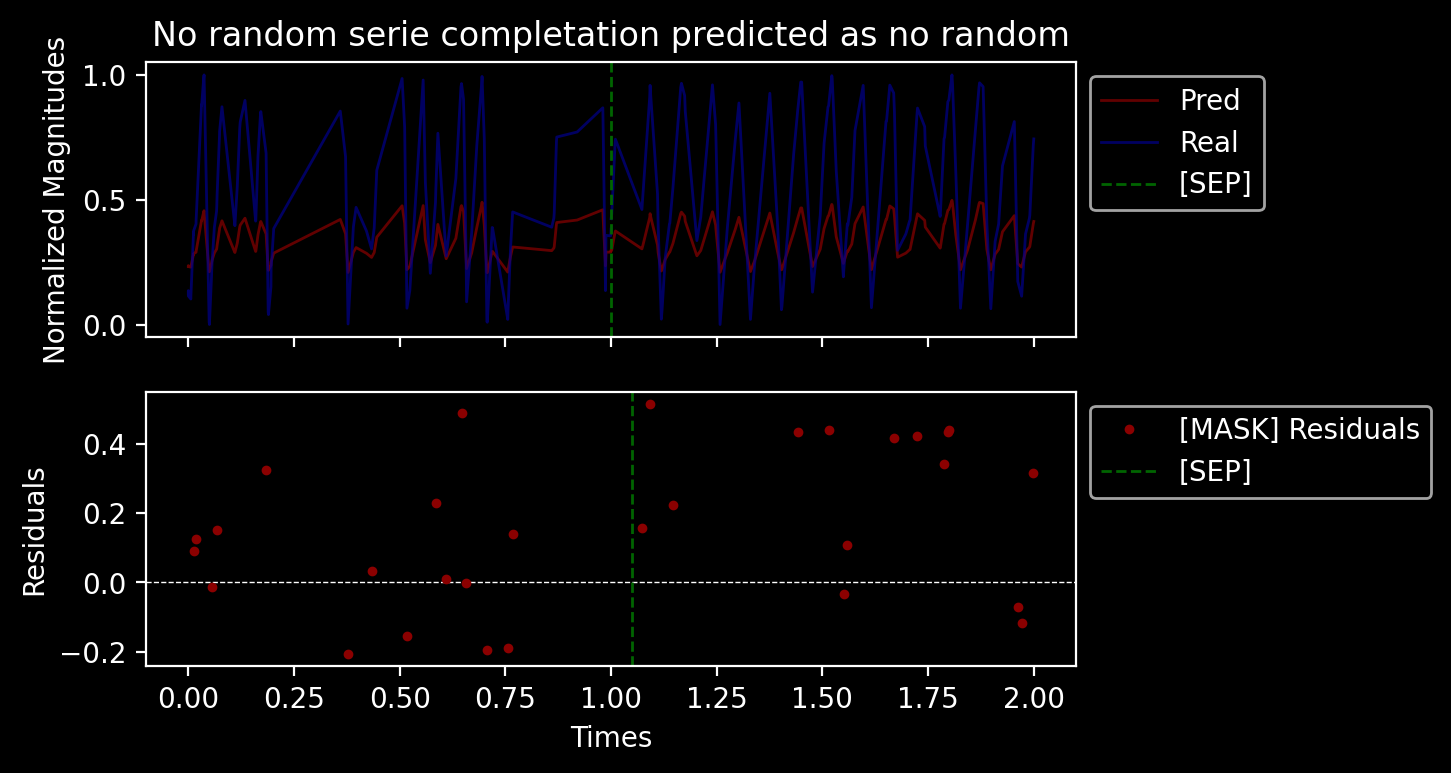

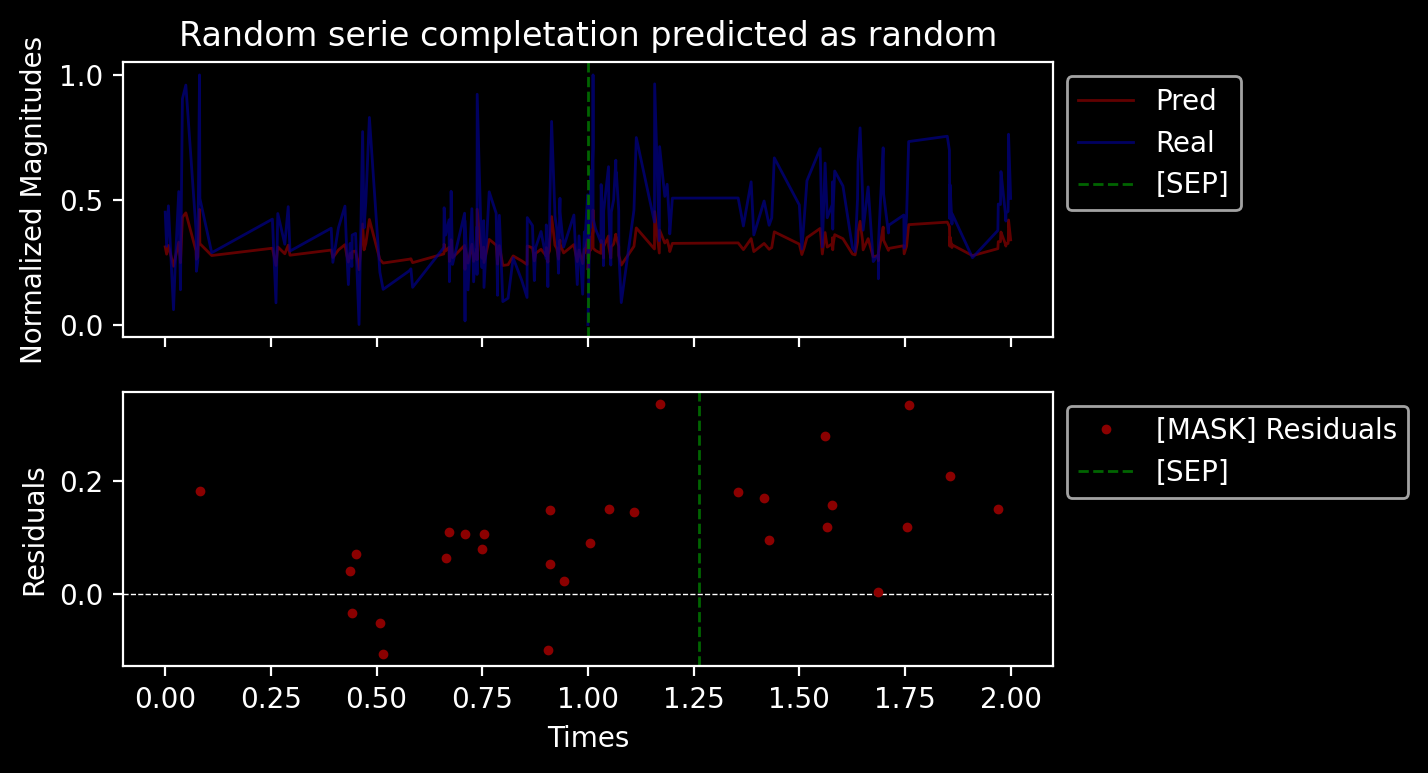

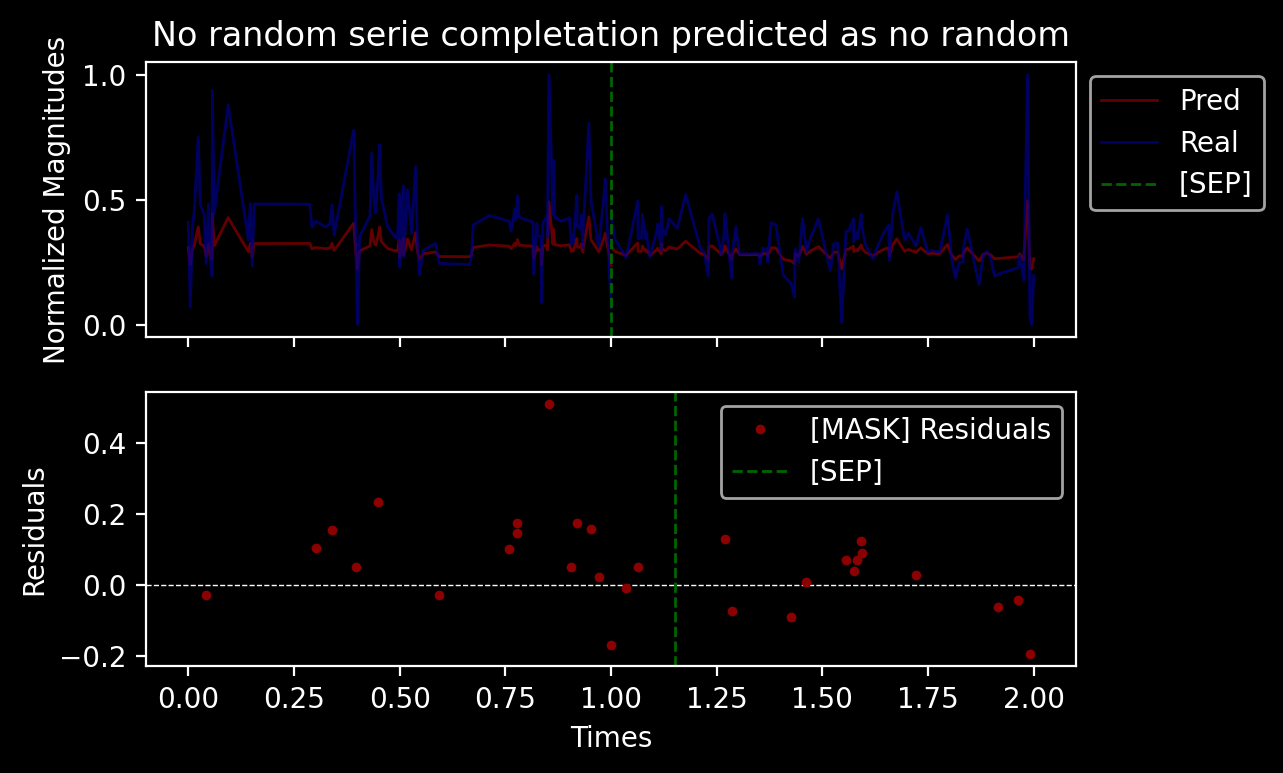

In [21]:
n = 0
for n in range(3):
    fig, axes = plt.subplots(2, 1, dpi=200, sharex=True, sharey=False)
    y_pred = rec_pred[n]
    y_true = rec_true[n]
    mask = rec_mask[n]
    l_pred = cls_pred[n]
    l_true = cls_true[n]
    x_time = rec_times[n]    

    lim = tf.where(x_time == 102).numpy()[0][0]
    
    axes[0].plot(x_time[:lim], y_pred[:lim], color='darkred', linewidth=1, label='Pred', alpha=0.7)
    axes[0].plot(x_time[:lim], y_true[:lim], color='darkblue', linewidth=1, label='Real', alpha=0.7)
    
    axes[0].plot(x_time[lim+1:]+1, y_pred[lim+1:], color='darkred', linewidth=1, alpha=0.7)
    axes[0].plot(x_time[lim+1:]+1, y_true[lim+1:], color='darkblue', linewidth=1, marker='',linestyle='-', alpha=0.7)
    
    axes[0].axvline(x=x_time[lim+1]+1, color='darkgreen', linewidth=1, linestyle='--', label='[SEP]')
    
    x_time_masked = tf.boolean_mask(x_time, mask)
    lim = tf.where(x_time_masked == 102).numpy()[0][0]
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    y_true_masked = tf.boolean_mask(y_true, mask)
    

    axes[1].axhline(y=0, color='white', linewidth=0.5, linestyle='--')
    axes[1].plot(x_time_masked[:lim], y_true_masked[:lim]-y_pred_masked[:lim], 
                 color='darkred', linestyle='',marker='.', markersize=5, label='[MASK] Residuals')
    axes[1].plot(x_time_masked[lim+1:]+1, y_true_masked[lim+1:]-y_pred_masked[lim+1:], 
                 color='darkred', linestyle='',marker='.', markersize=5,)
   
    name1 = 'no random' if l_pred == 0 else 'random'
    name2 = 'No random' if l_true == 0 else 'Random'
    
    axes[0].set_title('{} serie completation predicted as {}'.format(name2, name1))
    
    axes[1].axvline(x=x_time[lim+1]+1, color='darkgreen', linewidth=1, linestyle='--', label='[SEP]')
    
    axes[0].legend(bbox_to_anchor=(1, 1))
    axes[1].legend(bbox_to_anchor=(1, 1))
    
    axes[0].set_ylabel('Normalized Magnitudes')
    axes[1].set_ylabel('Residuals')
    axes[1].set_xlabel('Times')
    
    plt.show()